<a href="https://colab.research.google.com/github/Jholman22/Notebooks_TAM/blob/main/1_Clasificadores_clasicos_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación multiclase - comparación de métodos utilizando validación cruzada

- Se presenta un esquema completo de comparación de clasifacadores en la base de datos People Labaled Faces in the Wild, aka Labeled Faces in the Wild ([LFW](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html)).

- Además, se plantean algunos ejercicios teórico-prácticos relacionados con tareas de clasificación utilizando aprendizaje de máquina clásico.

- Se plantean algunas funciones para el cálculo de curvas ROC, medidas de rendimiento y gráficas básicas

In [ ]:
#librerias a importar
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import roc_curve, auc
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

#crear carpeta resultados
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

#%%  guardar figuras
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path)

import seaborn as sns

#curvas roc multiclase
def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):
    lw = 2
    # Falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # roc
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) #interpolar para suavizar
    # promediado sobre numero de clases
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # graficar
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))
    plt.show()


#matriz confusión = #[[TN FP][FN TP]]
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


# ROC curve and ROC
def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes

def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    gráfica la matriz de confusión con y sin normalización
    """
    if not title:
        title = 'Matriz de confusión'

    # calcular matriz de confusión
    cm = 100*confusion_matrix(y_true, y_pred,normalize="true")
    # se identifican las etiquetas en los datos
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # mostrar ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta original',
           xlabel='Predicción')

    # Rotar ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # textos.
    fmt = '.1f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Lectura base de datos LFW

- Se carga la base de datos desde los repositorios de sklearn.

Dimensiones tipo pandas:  (1288, 1850)
Dimensiones tipo imágen: (1288, 50, 37)


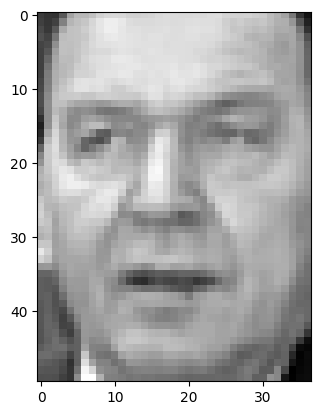

In [ ]:
#Lectura base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)/255
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
print('Dimensiones tipo imágen:',lfw_people.images.shape)
plt.imshow(np.array(Xdata.iloc[300,:]).reshape(lfw_people.images.shape[1],
                                             lfw_people.images.shape[2]),cmap='gray')
plt.show()

# HoldOut evaluación

- Se particiona el conjunto de datos en 70% para entrenamiento y 30% para evaluación.

In [ ]:
#Particion entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.3, random_state=123)
Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
510,0.000836,0.001143,0.001446,0.001666,0.001897,0.001994,0.002066,0.002071,0.002097,0.002138,...,0.000549,0.001384,0.002332,0.003189,0.003645,0.003727,0.003101,0.000856,0.000395,0.000466
1035,0.001589,0.001758,0.001922,0.002409,0.002819,0.002958,0.002917,0.002830,0.002830,0.002737,...,0.000297,0.000374,0.000384,0.000436,0.000359,0.000369,0.000420,0.000497,0.000466,0.000466
176,0.000892,0.001205,0.001210,0.001287,0.001492,0.001687,0.001763,0.001779,0.001845,0.001866,...,0.000451,0.000446,0.000482,0.000472,0.000477,0.000466,0.000513,0.000559,0.000600,0.000538
620,0.000267,0.000584,0.001446,0.002230,0.002507,0.002512,0.002491,0.002532,0.002584,0.002594,...,0.001333,0.001389,0.000723,0.000133,0.000190,0.000251,0.000313,0.000400,0.000549,0.000666
689,0.002261,0.002409,0.001958,0.001753,0.002127,0.002907,0.002932,0.002676,0.002655,0.002799,...,0.001569,0.001512,0.001548,0.001615,0.001794,0.002276,0.003106,0.003522,0.003573,0.003578


# Búsqueda de parámetros utilizando gridsearchCV

**Nota**: Recuerde que GridsearchCV utiliza validación cruzada para encontrar los mejores hiperparámetros según los rendimientos promedios en el conjunto de test (validación si se considera la partición original)


![cv](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/grid_search_cross_validation.png?raw=1)

In [ ]:
#%% Escoger modelo por gridsearchCV utilizando pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib

#se crean listas de steps (pipelines)
steps=[[('nor', MinMaxScaler()),
        ('cla', LogisticRegression())], #Pipeline1
       [('nor',  MinMaxScaler()),
        ('cla', SGDClassifier())],#Pipeline2
        [('nor',MinMaxScaler()),
         ('cla', SVC())]#Pipeline3
      ]

parameters = [{
              'cla__C': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline1 - hyperparametros
              },
              {
              'cla__alpha': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline2 - hyperparametros
              },
              {
             'cla__C': [1,10,1e2,1e3,1e4],
             'cla__gamma': [1e-3, 1e-2, 1e-1,1, 10]    #Pipeline2 - hyperparametros
             }
             ]

label_models = ['MinMax_Logistic','MinMax_SGD', 'MinMax_SVCrbf']

models = []
filename = 'results/lfw_models'
for i in range(len(steps)): # recorrer modelos según lista pipeline
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='accuracy',refit= True,verbose=10)#gridsearch para modelo i
    grid_search.fit(Xtrain, ytrain)
    #mejor modelo entrenado
    models += [grid_search] #guardar modelos
    joblib.dump(models,filename+".pkl")

modelo 1/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 2/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 3/3
Fitting 5 folds for each of 25 candidates, totalling 125 fits


# Rendimientos utilizando validación cruzada (conjuntos entrenamiento y validación)

- Se muestran los resultados de la validación cruzada para los mejores modelos encontrados en el gridsearch

- Para utilizar distintos scores de entrenamiento en clasificación ver [https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

**Nota**: el argumento `refit=True` en GridsearchCV asegura reentrenar el mejor modelo encontrado utilizando toda la base de datos, pensando en generalizar bien sobre el conjunto de test.

In [ ]:
ind = models[2].cv_results_['mean_test_score'].argmax()#encontrar rendimiento más alto sobre CV del gridsearch en test
models[i].cv_results_['mean_test_score'][i]


0.43286065070595453

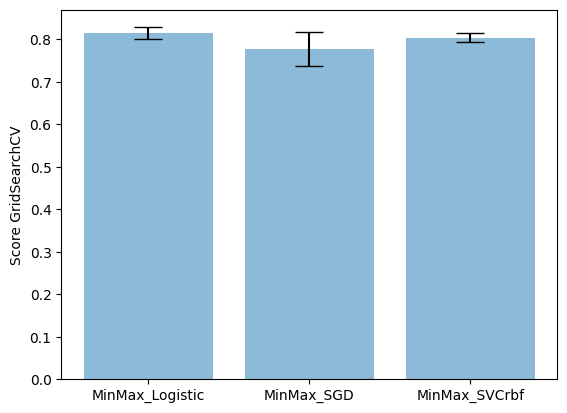

['MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVCrbf']
[[0.815 0.777 0.804]
 [0.014 0.04  0.011]]


In [ ]:
#recorrer modelos
bars_ = np.zeros((2,len(models)))#arreglo de barras para graficar mejores modelos en promedio con std
for i in range(len(models)):
  ind = models[i].cv_results_['mean_test_score'].argmax()#se determina el mejor score de clasificación
  bars_[0,i] = models[i].cv_results_['mean_test_score'][ind]#guardar score promedio del mejor modelo
  bars_[1,i] = models[i].cv_results_['std_test_score'][ind]#guardar std del mejor modelo

plt.bar(np.arange(len(models)), bars_[0], yerr=bars_[1], align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('Score GridSearchCV')
plt.xticks(np.arange(len(models)))
plt.gca().set_xticklabels(label_models)
plt.show()

print(label_models)
print(np.round(bars_,3))

# Calcular rendimiento en cojunto de test

- En caso práctico y buscando cuantificar la generalización de los modelos, se cálcula el rendimiento sobre el conjunto de test original.

- Se presentan las matrices de confusión y se utiliza el método [`classification report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) de sklearn para calcular las medidas de acierto, precision, exhaustividad, f1.

**Nota**: Es importante tener en cuenta que los resultados de comparación incluyen promediados simples, sopesados en términos de la probabilidad marginal de cada clase, además de promediados [micro y macro](https://www.educative.io/answers/what-is-the-difference-between-micro-and-macro-averaging).

Evaluando modelo MinMax_Logistic (1/3)


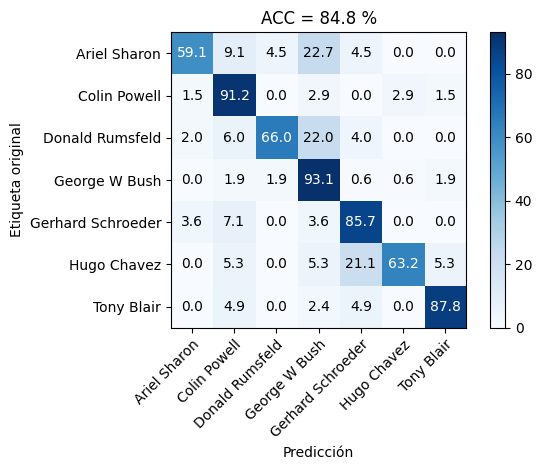

                   precision    recall  f1-score   support

     Ariel Sharon       0.81      0.59      0.68        22
     Colin Powell       0.83      0.91      0.87        68
  Donald Rumsfeld       0.89      0.66      0.76        50
    George W Bush       0.88      0.93      0.90       159
Gerhard Schroeder       0.71      0.86      0.77        28
      Hugo Chavez       0.80      0.63      0.71        19
       Tony Blair       0.88      0.88      0.88        41

         accuracy                           0.85       387
        macro avg       0.83      0.78      0.80       387
     weighted avg       0.85      0.85      0.84       387

Evaluando modelo MinMax_SGD (2/3)


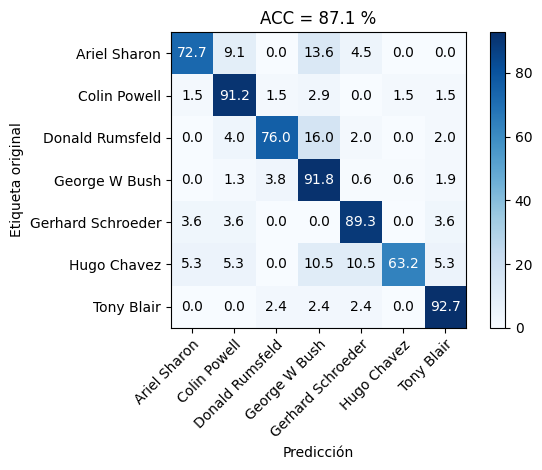

                   precision    recall  f1-score   support

     Ariel Sharon       0.84      0.73      0.78        22
     Colin Powell       0.89      0.91      0.90        68
  Donald Rumsfeld       0.83      0.76      0.79        50
    George W Bush       0.90      0.92      0.91       159
Gerhard Schroeder       0.81      0.89      0.85        28
      Hugo Chavez       0.86      0.63      0.73        19
       Tony Blair       0.84      0.93      0.88        41

         accuracy                           0.87       387
        macro avg       0.85      0.82      0.83       387
     weighted avg       0.87      0.87      0.87       387

Evaluando modelo MinMax_SVCrbf (3/3)


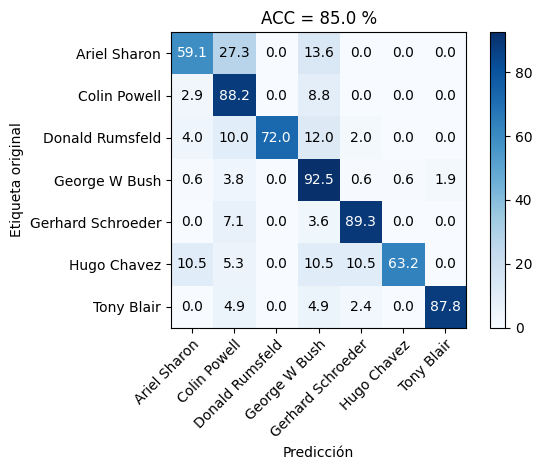

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.59      0.62        22
     Colin Powell       0.73      0.88      0.80        68
  Donald Rumsfeld       1.00      0.72      0.84        50
    George W Bush       0.88      0.92      0.90       159
Gerhard Schroeder       0.83      0.89      0.86        28
      Hugo Chavez       0.92      0.63      0.75        19
       Tony Blair       0.92      0.88      0.90        41

         accuracy                           0.85       387
        macro avg       0.85      0.79      0.81       387
     weighted avg       0.86      0.85      0.85       387



In [ ]:
#%% evaluar sobre Xtest
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].best_estimator_.predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)

    plot_confusion_matrix(
                          ytest, ytest_e,
                          classes=lfw_people.target_names,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
    #save_fig(path_img,label_models[i])
    plt.show()

    cr = classification_report(
                               ytest, ytest_e,
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )
    #support = #muestras en la clase estudiada
    print(cr)


## Curva ROC multiclase - sobre conjunto de test

- Finalmente, se presentan las curvas ROC multiclase.

**Nota**: Se debe ajustar la líne de código donde se cálcula el score de predicción en términos de la función de decisión (decision_function) o la probilidad de la predicción (predict_proba), según el tipo de modelo.

Por ejemplo: la  [´SVC´](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) utiliza el método decision function, el [´KnearestNeighborsClassifier´](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) utiliza el método predict proba.

Evaluando modelo MinMax_Logistic (1/3)


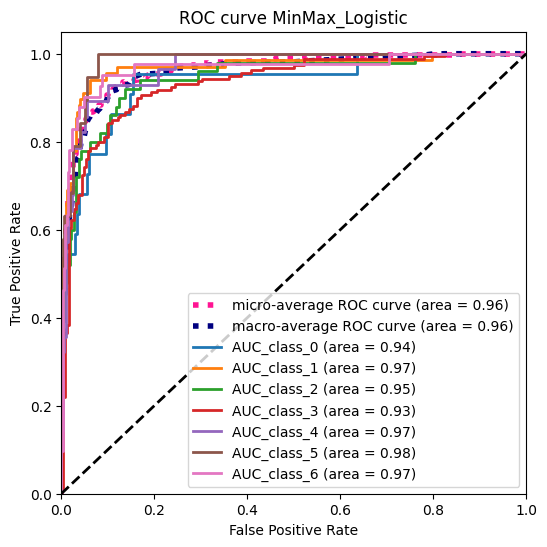

Evaluando modelo MinMax_SGD (2/3)


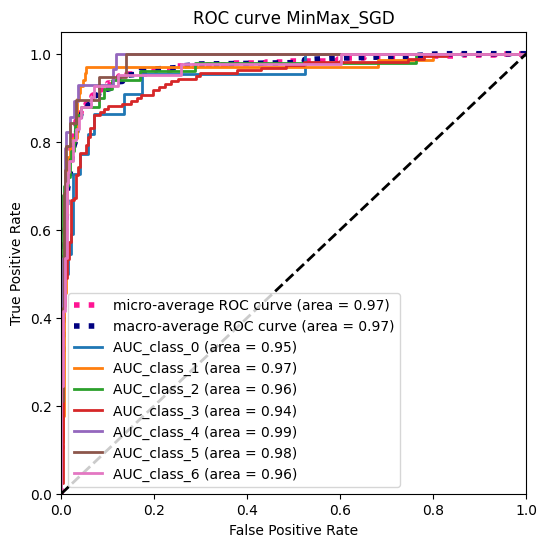

Evaluando modelo MinMax_SVCrbf (3/3)


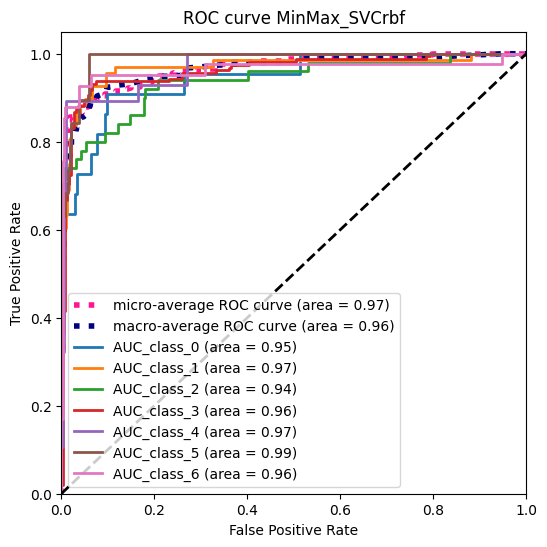

In [ ]:
from sklearn.preprocessing import label_binarize

ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))

for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))
    #debe calcularse la funcion de decision o el posterior de la probabilidad
    ytest_score = my_model_loaded[i].decision_function(Xtest)
    roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
    roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)


# Ejercicio

1. Consulte y presente el modelo y problema de optimización de los siguientes clasificadores:

- [Naive_Bayes.GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
- [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)
- [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)
- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

2. Utilizando un esquema de validación cruzada de 5 folds sobre el conjunto de entrenamiento, compare el rendimiento de los métodos del punto 1. Emplee optimización Bayesiana de hiperparámetros, fijando el score en términos del acc, el f1 y el AUC.


#  **1. Modelo Naive Bayes Gaussiano**


1.   Elemento de lista
2.   Elemento de lista


### 🔹 Naturaleza del modelo
El Naive Bayes Gaussiano es un modelo **supervisado, probabilístico y generativo**, basado en el **teorema de Bayes**. Se utiliza para clasificación y parte de dos suposiciones clave:
- Las características son **condicionalmente independientes** entre sí, dado la clase (*naive assumption*).
- Cada característica sigue una **distribución normal (gaussiana)** dentro de cada clase.

---

### 🔹 Objetivo del clasificador
Dado un nuevo vector de características \( X = (x_1, x_2, ..., x_n) \), el objetivo es predecir la clase \( \hat{y} \) que tenga la mayor probabilidad posterior:

$$
\hat{y} = \arg\max_{C_k} P(C_k \mid X)
$$

Aplicando el teorema de Bayes:

$$
P(C_k \mid X) = \frac{P(X \mid C_k) \cdot P(C_k)}{P(X)}
$$

Como \( P(X) \) es constante para todas las clases, se maximiza:

$$
P(X \mid C_k) \cdot P(C_k)
$$

---

### 🔹 Suposición de independencia
Se asume que las características son independientes entre sí, condicionales a la clase. Entonces:

$$
P(X \mid C_k) = \prod_{i=1}^{n} P(X_i \mid C_k)
$$

Esto reduce el problema de estimar una distribución multivariada a estimar distribuciones individuales.

---

### 🔹 Suposición Gaussiana
Cada característica \( X_i \) se modela como una variable aleatoria con distribución normal dentro de cada clase \( C_k \):

$$
P(X_i \mid C_k) = \frac{1}{\sqrt{2\pi \sigma_{ik}^2}} \exp\left( - \frac{(X_i - \mu_{ik})^2}{2\sigma_{ik}^2} \right)
$$

Donde:
- \( \mu_{ik} \): media de \( X_i \) en la clase \( C_k \)
- \( \sigma_{ik}^2 \): varianza de \( X_i \) en la clase \( C_k \)

---

### 🔹 Estimación de parámetros
Los parámetros se estiman directamente de los datos (estimación cerrada):

- **Probabilidad a priori de cada clase**:

$$
P(C_k) = \frac{N_k}{N}
$$

- **Media y varianza de cada característica por clase**:

$$
\mu_{ik} = \frac{1}{N_k} \sum_{j : y_j = C_k} x_{ij}
\quad , \quad
\sigma_{ik}^2 = \frac{1}{N_k} \sum_{j : y_j = C_k} (x_{ij} - \mu_{ik})^2
$$

---

### 🔹 Clasificación de nuevos datos
Para una observación nueva \( X = (x_1, ..., x_n) \), se calcula:

$$
\text{Score}_k = \log P(C_k) + \sum_{i=1}^{n} \log P(X_i \mid C_k)
$$

La clase predicha será aquella con el mayor score. Se usa logaritmo para evitar problemas numéricos.

---


#  **Clasificador SGD (Stochastic Gradient Descent)**

Se trata de un modelo supervisado que entrena un clasificador lineal (como regresión logística o SVM) usando el algoritmo de **descenso de gradiente estocástico**.

---

###  Principios Fundamentales

- **Descenso de gradiente**: técnica de optimización que ajusta los parámetros del modelo siguiendo la dirección del gradiente de la función de pérdida, para minimizar el error.

- **Estocástico**: a diferencia del descenso de gradiente tradicional (que usa todos los datos en cada paso), aquí se actualiza el modelo utilizando **una sola muestra aleatoria** por iteración, lo que permite un entrenamiento más rápido en conjuntos de datos grandes.

---

##  Estructura del Modelo

El modelo es de tipo lineal y se representa como:

$$
f(x) = W^T X + b
$$

Donde:

- \( X \in \mathbb{R}^n \): vector de entrada o características  
- \( W \in \mathbb{R}^n \): pesos o coeficientes del modelo  
- \( b \in \mathbb{R} \): término de sesgo (bias)  

**Interpretación geométrica**:
- \( W \): define la dirección u orientación del hiperplano
- \( b \): ajusta la posición de la frontera de decisión

---

###  Clasificación

La decisión del modelo depende del signo de la función \( f(x) \):

- Si \( f(x) > 0 \), se predice la clase 1  
- Si \( f(x) < 0 \), se predice la clase 0  

La superficie que separa las clases es un **hiperplano**.  
En dos dimensiones, esto se traduce en una línea:

$$
W_1 X_1 + W_2 X_2 + b = 0
$$

---

##  Función Objetivo

El entrenamiento busca minimizar una función de pérdida regularizada, que combina error de predicción y penalización por complejidad del modelo:

$$
\min_{W, b} \ \frac{1}{m} \sum_{i=1}^{m} L(y_i, f(x_i)) + \lambda R(W)
$$

Donde:

- \( L(y_i, f(x_i)) \): pérdida por ejemplo \( i \) (puede ser logística, hinge, etc.)
- \( R(W) \): término de regularización (como \( L_2 = ||W||^2 \) o \( L_1 = ||W|| \))
- \( \lambda \): hiperparámetro que controla la fuerza de la regularización

---

##  Algoritmo de Entrenamiento (SGD)

El modelo se entrena iterativamente con el siguiente procedimiento:

1. Se selecciona una muestra aleatoria \( (x_i, y_i) \)  
2. Se calcula el gradiente de la pérdida para esa muestra:  
   - \( \nabla W_i = \frac{\partial L_i}{\partial W} \)  
   - \( \nabla b_i = \frac{\partial L_i}{\partial b} \)  
3. Se actualizan los parámetros:

$$
W \leftarrow W - \eta \cdot \nabla W_i
$$

$$
b \leftarrow b - \eta \cdot \nabla b_i
$$

Donde:

- \( \eta \) es la **tasa de aprendizaje**
- \( L_i \) es la pérdida evaluada solo en esa muestra específica

Este proceso se repite para muchas iteraciones o "épocas", hasta que los parámetros converjan a valores óptimos.

---


# **Regresión Logística**

La regresión logística es un modelo lineal para **clasificación binaria**, utilizado para estimar la **probabilidad** de que una muestra pertenezca a la clase positiva (por ejemplo, $y = 1$).

---

##  Modelo Matemático

Dado un vector de entrada $x \in \mathbb{R}^n$, el modelo predice:

$$
P(y = 1 \mid x) = \sigma(W^T x + b)
$$

Donde:

- $(W \in \mathbb{R}^n)$: vector de pesos del modelo  
- $(b \in \mathbb{R})$: término de sesgo (bias)  
- $\sigma(z) = \frac{1}{1 + e^{-z}}$: función logística o **sigmoide**

Este valor está entre 0 y 1, y se interpreta como una **probabilidad**.

---

##  Función de Pérdida: Log-loss (entropía cruzada)

Para una muestra $(x_i, y_i)$, definimos $g_i = \sigma(W^T x_i + b)$. La pérdida asociada es:

$$
L(y_i, g_i) = -y_i \log(g_i) - (1 - y_i) \log(1 - g_i)
$$

Esta función penaliza más cuando el modelo predice una probabilidad lejana al valor real de $y_i$.

---

##  Problema de Optimización

En un conjunto de entrenamiento con $m$ ejemplos, el objetivo es minimizar:

$$
\min_{W, b} \ \frac{1}{m} \sum_{i=1}^{m} \left[ -y_i \log(g_i) - (1 - y_i) \log(1 - g_i) \right] + \lambda ||W||^2
$$

Donde:

- El primer término es la **pérdida promedio** (log-loss)  
- El segundo es la **regularización L2** (con coeficiente $\lambda$), que ayuda a evitar el sobreajuste  

---

##  Gradientes para entrenamiento

Para una sola muestra, con $z = W^T x + b$ y $\sigma(z)$ la salida del modelo:

- **Función de pérdida**:

$$
L(W, b) = -y \log(\sigma(z)) - (1 - y) \log(1 - \sigma(z))
$$

- **Gradiente respecto a los pesos**:

$$
\nabla_W L = (\sigma(z) - y) \cdot x
$$

- **Gradiente respecto al sesgo**:

$$
\nabla_b L = \sigma(z) - y
$$

---

##  Regla de Actualización (Descenso de Gradiente)

Los parámetros del modelo se actualizan así:

$$
W \leftarrow W - \eta \cdot \nabla_W L
$$

$$
b \leftarrow b - \eta \cdot \nabla_b L
$$

Donde $\eta$ es la **tasa de aprendizaje**, que controla el tamaño del paso en cada iteración.

---


# **Análisis Discriminante Lineal (LDA)**

El Análisis Discriminante Lineal (LDA) es un modelo de clasificación **supervisado y lineal** que:

- Parte del supuesto de que los datos de cada clase provienen de una **distribución normal multivariada**, con una **misma matriz de covarianza** para todas las clases.
- Busca una dirección de proyección en la que se **maximice la separación entre clases**.
- Se basa en principios **probabilísticos** y utiliza una **transformación lineal** de los datos.

---

### 🔹 Supuestos fundamentales

1. Cada clase $( C_k )$ genera observaciones $X \in \mathbb{R}^d$ siguiendo una distribución normal multivariada:

$$
X \sim \mathcal{N}(\mu_k, \Sigma)
$$

donde $\mu_k$ representa la media de la clase $( C_k )$, y $\Sigma$ es la **misma matriz de covarianza** para todas las clases.

2. La matriz de covarianza es **compartida entre todas las clases**:

$$
\Sigma_1 = \Sigma_2 = \cdots = \Sigma
$$

3. Se conocen o se estiman las **probabilidades a priori** de cada clase:

$$
P(C_k)
$$

---

##  Modelo de LDA

La predicción de la clase se realiza maximizando la siguiente función discriminante:

$$
\hat{y} = \arg\max_k \ \delta_k(x)
$$

donde la función discriminante lineal para la clase $( C_k )$ está dada por:

$$
\delta_k(x) = x^T \Sigma^{-1} \mu_k - \frac{1}{2} \mu_k^T \Sigma^{-1} \mu_k + \log P(C_k)
$$

---

###  Propiedades del modelo

- La función $\delta_k(x)$ es **lineal respecto a $x$**, lo cual hace que LDA sea un **modelo lineal**.


#**K-Nearest Neighbors (KNN)**

KNN es un **clasificador supervisado no paramétrico**.

Esto quiere decir que **no construye un modelo explícito durante el entrenamiento**, sino que simplemente **almacena todas las muestras del conjunto de entrenamiento**.

---

### 🔹 ¿Cómo realiza la predicción?

Cuando se recibe una nueva observación $x$, el procedimiento de KNN es el siguiente:

1. Calcula la **distancia** entre $x$ y cada muestra del conjunto de entrenamiento  
2. Identifica los **$k$ puntos más próximos** a $x$ (es decir, sus vecinos)  
3. Asigna a $x$ la **clase más frecuente** entre esos $k$ vecinos

---

##  Representación del modelo KNN

Aunque el modelo no tiene una expresión analítica directa, puede describirse de la siguiente forma:

Dado el conjunto de entrenamiento:

$$
D = \{ (x_1, y_1), (x_2, y_2), ..., (x_n, y_n) \}
$$

y una nueva instancia $x$, la clase predicha es:

$$
\hat{y} = \text{modo} \{ y_j \, | \, x_j \in N_k(x) \}
$$

Donde:

- $N_k(x)$ representa el conjunto de los $k$ vecinos más cercanos a $x$ según una métrica (por ejemplo, **distancia euclidiana**)
- $\text{modo}$ indica la **clase más común** entre esos vecinos

---

##  Criterio de decisión

KNN **no resuelve una función de costo global**, pero puede interpretarse como un algoritmo que **minimiza el error de clasificación en el entorno local** del punto de entrada.

Formalmente:

$$
\hat{y}(x) = \arg\max_{c \in \text{clases}} \sum_{x_i \in N_k(x)} \mathbb{1}(y_i = c)
$$

Donde:

- $\mathbb{1}(y_i = c)$ es una función indicadora que vale 1 si el vecino $x_i$ pertenece a la clase $c$, y 0 en caso contrario  
- $\hat{y}(x)$ es la clase asignada a la muestra $x$  
- $c \in \text{clases}$ recorre todas las clases posibles en el conjunto de datos

---



# **Clasificador de Vectores de Soporte Lineal (Linear SVC)**

El **Linear SVC** es un modelo de clasificación **supervisado** que busca construir un **hiperplano lineal** que **divida dos clases** maximizando la **distancia (margen)** entre ellas.

Corresponde a una versión lineal del modelo **SVM (Support Vector Machine)**, pero con métodos de optimización más eficientes para conjuntos grandes.

---

### 🔹 Estructura del modelo

La forma funcional del modelo es:

$$
f(x) = W^T x + b
$$

La predicción final se realiza aplicando el signo de la salida:

$$
\hat{y} = \text{sign}(W^T x + b)
$$

Donde:

- $W$ es el **vector de pesos**, que determina la orientación del hiperplano  
- $b$ es el **término de sesgo** o desplazamiento  
- $x$ es el **vector de características** de entrada

---

###  Concepto de margen

El **margen** es la distancia entre el hiperplano y los ejemplos más cercanos de cada clase, conocidos como **vectores de soporte**.

El objetivo del modelo es **maximizar este margen**, ya que un margen más amplio suele conducir a una **mejor capacidad de generalización**.

---

##  Optimización en el caso separable

Cuando los datos pueden separarse perfectamente, el problema se formula como:

$$
\min_{W, b} \ \frac{1}{2} ||W||^2
$$

Sujeto a:

$$
y_i (W^T x_i + b) \geq 1 \quad \text{para todo } i
$$

Esto asegura que todos los puntos estén **correctamente clasificados** y **fuera del margen**.

---

###  ¿Por qué se minimiza $||W||^2$?

La distancia desde un punto $x$ al hiperplano es:

$$
\text{distancia} = \frac{W^T x + b}{||W||}
$$

Maximizar esta distancia equivale a **minimizar la norma cuadrada de los pesos**: $||W||^2$.

---

##  Casos no separables: margen suave

Si las clases no son completamente separables, se introducen **variables de holgura** $\xi_i$ para permitir algunos errores.

El nuevo problema es:

$$
\min_{W, b, \xi} \ \frac{1}{2} ||W||^2 + C \sum_{i=1}^{n} \xi_i
$$

Sujeto a:

$$
y_i (W^T x_i + b) \geq 1 - \xi_i, \quad \xi_i \geq 0
$$

Donde:

- $\xi_i$ representa la **violación del margen** o el error de clasificación permitido  
- $C$ es un **hiperparámetro** que regula el **compromiso entre margen grande y errores tolerables**

---

##  Implementación práctica: función de pérdida hinge

En lugar de usar restricciones duras, el problema se resuelve con una **función de pérdida hinge**, que suaviza el problema:

$$
\min_{W, b} \ \frac{1}{2} ||W||^2 + C \sum_{i=1}^{n} \max(0, 1 - y_i (W^T x_i + b))
$$

Este enfoque es utilizado por algoritmos como `LinearSVC` de `sklearn`, permitiendo una implementación computacional eficiente.

---


# **Random Forest Classifier**

Es un modelo de **clasificación supervisado** basado en **ensembles de árboles de decisión**.

---

### 🌳 ¿Qué es?

- Un **árbol de decisión** aprende reglas simples (ej. “si $x_1 > 5$, entonces clase A”) para clasificar los datos.
- Un **Random Forest** construye **muchos árboles** (decenas, centenas o miles), cada uno entrenado con **distintos subconjuntos** de datos y/o características.
- Luego, hace un **voto mayoritario** entre esos árboles para tomar la decisión final.

---

## Modelo

- El modelo es un **conjunto de $T$ árboles**: $h_1(x), h_2(x), ..., h_T(x)$
- Cada árbol $h_t(x)$ produce una predicción de clase $c \in \{1, ..., K\}$
- La predicción final del Random Forest es:

$$
\hat{y}(x) = \text{modo} \{ h_1(x), h_2(x), ..., h_T(x) \}
$$

Es decir, la clase **más votada** entre los árboles.

---

## 🌱 ¿Cómo se construyen los árboles?

### a) Bootstrap (Bagging)

- Cada árbol se entrena con un **subconjunto aleatorio de los datos con reemplazo** (es decir, se puede repetir una misma muestra varias veces).

### b) Submuestreo de características

- En cada nodo de cada árbol, se selecciona un **subconjunto aleatorio de características** para decidir la mejor división.
- Esto da **diversidad** a los árboles y evita que todos sean iguales.

---

## Problema de optimización (por árbol)

Cada árbol individual realiza una **optimización local** en cada nodo:

- **Elegir** la característica y el **umbral** (valor numérico) que mejor separa las clases.
- Esta decisión se hace **greedily** (codiciosamente), sin pensar en el futuro.

Se usan **medidas de impureza** para decidir qué división es mejor:

---

## Medidas de Impureza

### 1. Gini Impurity

$$
\text{Gini} = 1 - \sum_{k=1}^{K} p_k^2
$$

- $p_k$: proporción de ejemplos de la clase $k$ en ese nodo.
- Gini mide **qué tan mezclado** está un nodo:
  - Si $p_k = 1$, entonces Gini = 0 → nodo puro.
  - Si hay mezcla balanceada, Gini es alto → mala división.

---

### 2. Entropía

$$
\text{Entropy} = - \sum_{k=1}^{K} p_k \log p_k
$$

- También mide impureza.
- Mide la "sorpresa" o **incertidumbre** en la clasificación.
  - Si $p_k = 1$, no hay incertidumbre → entropía = 0.
  - Si $p_k$ es pequeño, $\log(p_k)$ es grande (alta entropía).

---

## ¿Qué busca el árbol?

El árbol quiere **minimizar la impureza** (ya sea Gini o Entropía), dividiendo los datos de modo que las **hojas contengan ejemplos lo más puros posible**.

### Buenas divisiones:
- Si una rama contiene 100% perros y la otra 100% gatos → división perfecta.

### Malas divisiones:
- Si una rama tiene 50% perros y 50% gatos → alta impureza.

---

## Ejemplo de predicción:

| Nodo hoja | Clase A | Clase B | Predicción | Confianza |
|-----------|---------|---------|------------|-----------|
| Nodo 1    | 10      | 0       | Clase A    | 100%      |
| Nodo 2    | 7       | 3       | Clase A    | 70%       |
| Nodo 3    | 5       | 5       | Clase ?    | 50%       |

---

## Tipos de nodos

1. **Nodo raíz**: el nodo superior (el primero)
2. **Nodos internos**: nodos intermedios que hacen divisiones
3. **Hojas**: nodos finales que asignan la clase


#2

In [1]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 1.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import fetch_lfw_people
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, label_binarize

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

Dimensiones tipo pandas:  (1288, 1850)
Dimensiones tipo imágen: (1288, 50, 37)


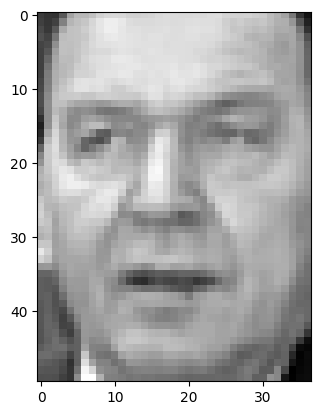

In [3]:
#Lectura base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)/255
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
print('Dimensiones tipo imágen:',lfw_people.images.shape)
plt.imshow(np.array(Xdata.iloc[300,:]).reshape(lfw_people.images.shape[1],
                                             lfw_people.images.shape[2]),cmap='gray')
plt.show()

In [4]:
# Partición 70/30
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, y, test_size=0.3, random_state=123, stratify=y)
Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
1015,0.001630,0.001661,0.001804,0.001902,0.001938,0.001984,0.002127,0.002194,0.002230,0.002302,...,0.001625,0.001728,0.002886,0.003568,0.003440,0.003204,0.002804,0.001646,0.000543,0.000410
106,0.000779,0.001077,0.001440,0.001707,0.001938,0.002215,0.002445,0.002553,0.002599,0.002686,...,0.002481,0.002548,0.002676,0.003055,0.003583,0.003804,0.003865,0.003886,0.003870,0.003850
105,0.001235,0.001374,0.001651,0.001666,0.001507,0.001543,0.001640,0.001738,0.001835,0.001943,...,0.001061,0.001241,0.001282,0.001415,0.002850,0.003409,0.003148,0.003142,0.003199,0.003142
849,0.001543,0.001866,0.002466,0.002727,0.002722,0.002609,0.002543,0.002548,0.002604,0.002640,...,0.002502,0.002358,0.003081,0.003660,0.003706,0.003686,0.002030,0.000559,0.000769,0.000851
812,0.001087,0.001358,0.001692,0.002061,0.002235,0.002466,0.002650,0.002671,0.002691,0.002748,...,0.001405,0.001635,0.001297,0.000272,0.000349,0.000420,0.000492,0.000559,0.000651,0.000672


In [5]:
pipelines = [
    Pipeline([('nor', MinMaxScaler()), ('cla', LogisticRegression(max_iter=1000))]),
    Pipeline([('nor', MinMaxScaler()), ('cla', SGDClassifier(max_iter=1000))]),
    Pipeline([('nor', MinMaxScaler()), ('cla', SVC(probability=True))]),
    Pipeline([('nor', MinMaxScaler()), ('cla', RandomForestClassifier())]),
    Pipeline([('nor', MinMaxScaler()), ('cla', GaussianNB())]),
    Pipeline([('nor', MinMaxScaler()), ('cla', LinearDiscriminantAnalysis())]),
    Pipeline([('nor', MinMaxScaler()), ('cla', KNeighborsClassifier())])
]

search_spaces = [
    {'cla__C': Real(1e-3, 1e3, prior='log-uniform')},
    {'cla__alpha': Real(1e-4, 1e2, prior='log-uniform')},
    {'cla__C': Real(1, 1e4, prior='log-uniform'), 'cla__gamma': Real(1e-3, 10, prior='log-uniform')},
    {'cla__n_estimators': Integer(10, 200), 'cla__max_depth': Integer(1, 20), 'cla__max_features': Categorical(['sqrt', 'log2'])},
    {},
    {'cla__solver': Categorical(['svd'])},
    {'cla__n_neighbors': Integer(1, 20), 'cla__weights': Categorical(['uniform', 'distance']), 'cla__p': Integer(1, 2)}
]

label_models = ['Logistic', 'SGD', 'SVCrbf', 'RandomForest', 'NaiveBayes', 'LDA', 'KNN']


🔍 Optimizando Logistic...

🔍 Optimizando SGD...

🔍 Optimizando SVCrbf...

🔍 Optimizando RandomForest...

🔍 Optimizando NaiveBayes...

🔍 Optimizando LDA...

🔍 Optimizando KNN...


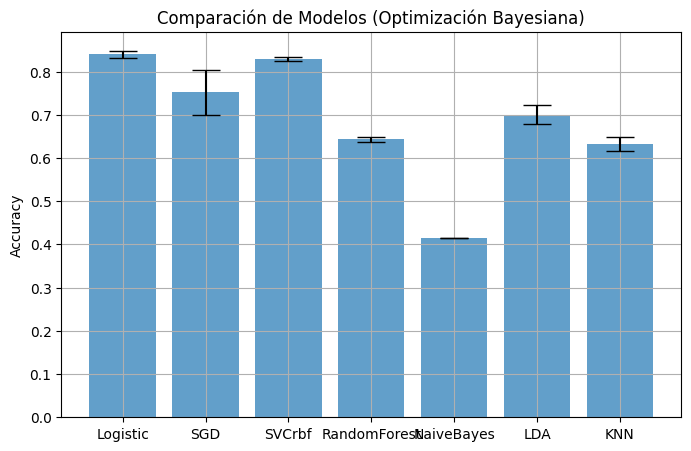

['modelos_bayes_7.pkl']

In [6]:
results = []
stds = []
models = []

for i, pipe in enumerate(pipelines):
    print(f"\n🔍 Optimizando {label_models[i]}...")

    if search_spaces[i]:
        opt = BayesSearchCV(pipe, search_spaces[i], n_iter=20, scoring='accuracy',
                            refit=True, cv=StratifiedKFold(5), n_jobs=-1, verbose=0)
        opt.fit(Xtrain, ytrain)
        best_model = opt
    else:
        pipe.fit(Xtrain, ytrain)
        best_model = pipe

    models.append(best_model)
    ypred = best_model.predict(Xtest)
    acc = accuracy_score(ytest, ypred)
    results.append(acc)

    if hasattr(best_model, 'cv_results_'):
        stds.append(best_model.cv_results_['std_test_score'][best_model.best_index_])
    else:
        stds.append(0.0)

# Visualización de barras
plt.figure(figsize=(8, 5))
plt.bar(np.arange(len(results)), results, yerr=stds, capsize=10, alpha=0.7)
plt.xticks(np.arange(len(label_models)), label_models)
plt.ylabel("Accuracy")
plt.title("Comparación de Modelos (Optimización Bayesiana)")
plt.grid(True)
plt.show()

# Guardar modelos
joblib.dump(models, 'modelos_bayes_7.pkl')

In [7]:
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.title(title)
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

def roc_multiclass(y_true_bin, y_score):
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(y_true_bin.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return roc_auc, fpr, tpr

def plot_roc_multiclass(fpr, tpr, roc_auc, model_name):
    plt.figure(figsize=(10, 8))
    for i in range(len(roc_auc)):
        plt.plot(fpr[i], tpr[i], label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'Curva ROC - {model_name}')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


📌 Logistic - ACC: 0.840
                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.65      0.75        23
     Colin Powell       0.88      0.85      0.86        71
  Donald Rumsfeld       0.72      0.78      0.75        37
    George W Bush       0.87      0.94      0.90       159
Gerhard Schroeder       0.79      0.70      0.74        33
      Hugo Chavez       0.93      0.67      0.78        21
       Tony Blair       0.76      0.81      0.79        43

         accuracy                           0.84       387
        macro avg       0.83      0.77      0.80       387
     weighted avg       0.84      0.84      0.84       387



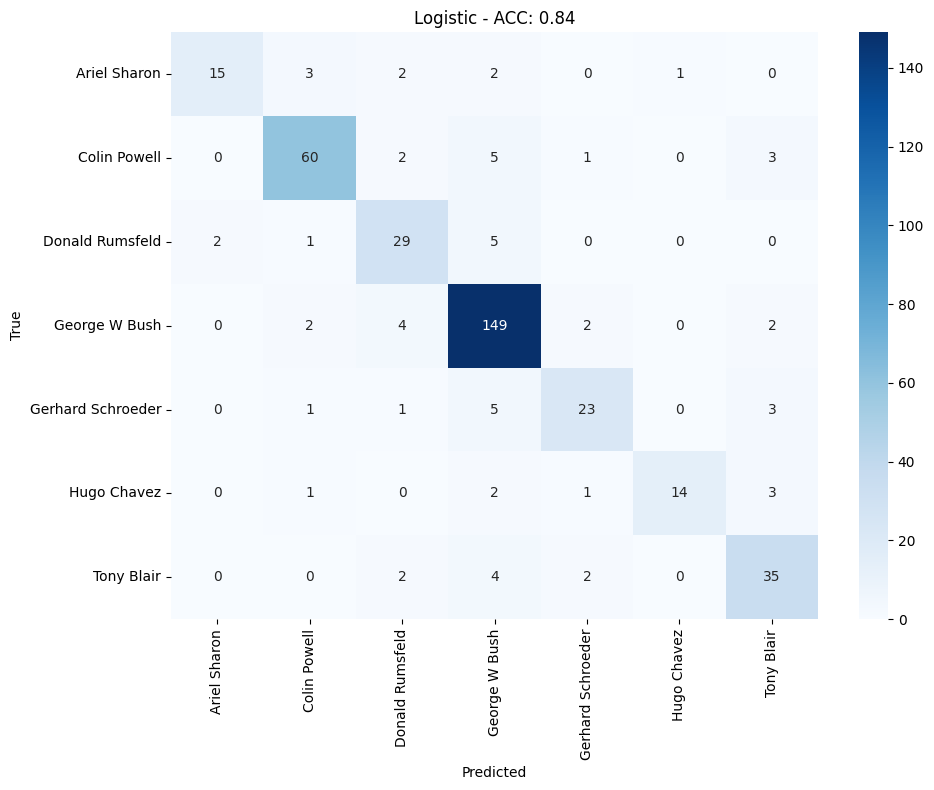

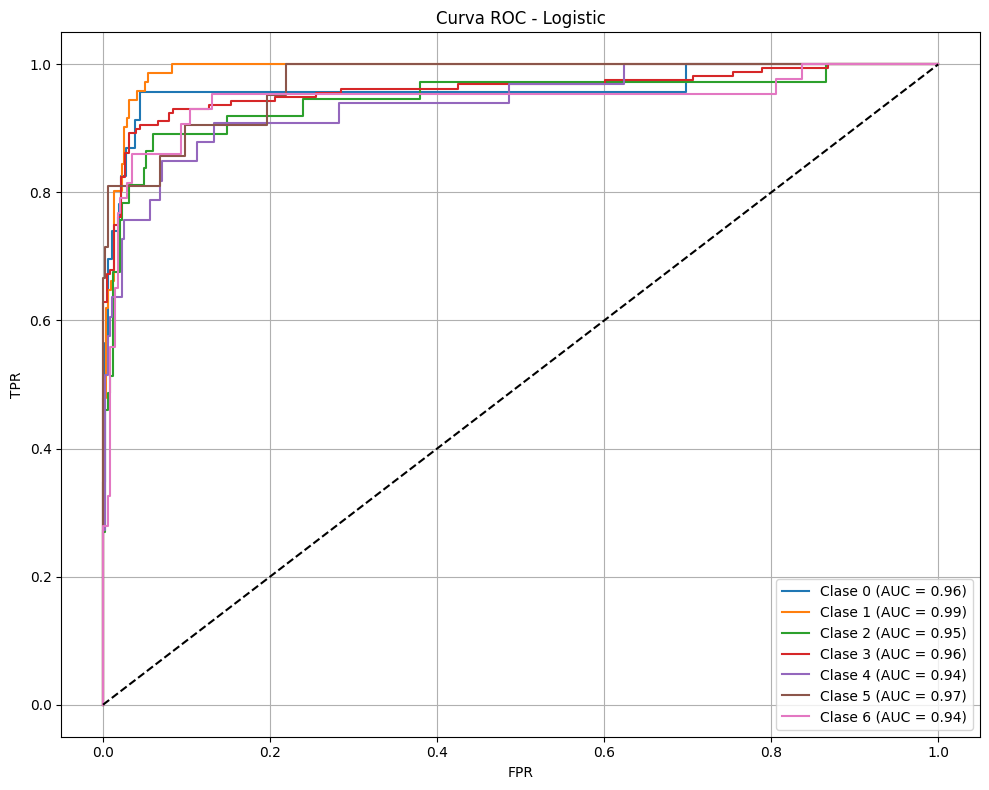


📌 SGD - ACC: 0.752
                   precision    recall  f1-score   support

     Ariel Sharon       0.91      0.43      0.59        23
     Colin Powell       0.63      0.92      0.75        71
  Donald Rumsfeld       0.86      0.32      0.47        37
    George W Bush       0.82      0.90      0.86       159
Gerhard Schroeder       1.00      0.30      0.47        33
      Hugo Chavez       0.75      0.71      0.73        21
       Tony Blair       0.65      0.84      0.73        43

         accuracy                           0.75       387
        macro avg       0.80      0.63      0.66       387
     weighted avg       0.79      0.75      0.73       387



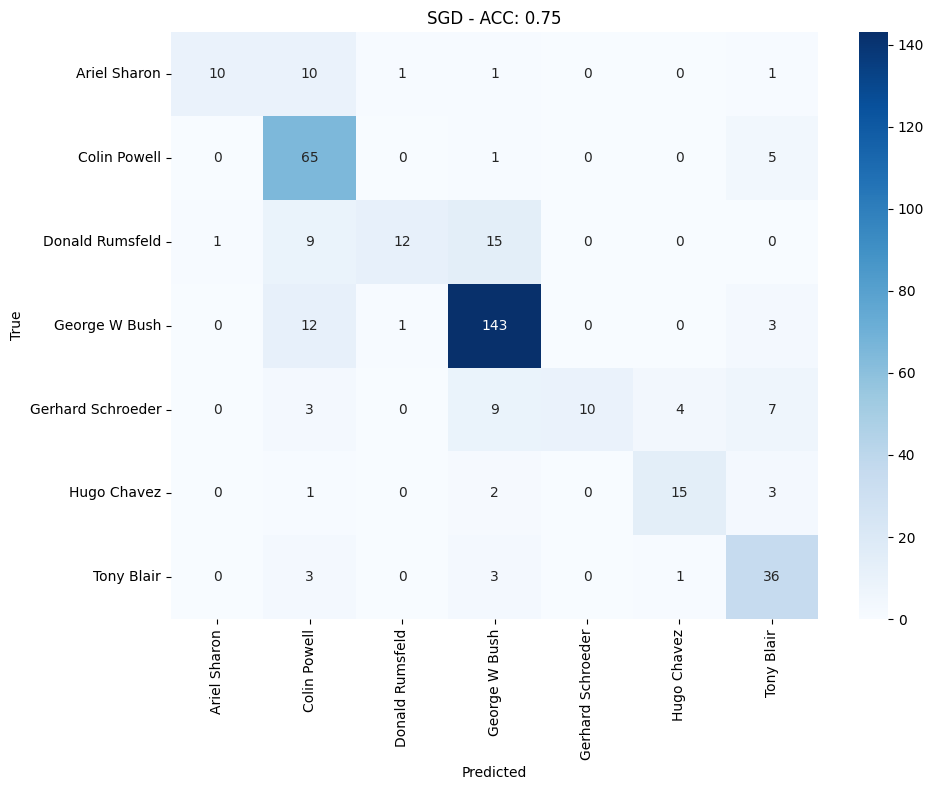

❌ No se pudo generar ROC para SGD: This 'Pipeline' has no attribute 'predict_proba'

📌 SVCrbf - ACC: 0.829
                   precision    recall  f1-score   support

     Ariel Sharon       0.68      0.74      0.71        23
     Colin Powell       0.85      0.89      0.87        71
  Donald Rumsfeld       0.75      0.65      0.70        37
    George W Bush       0.86      0.91      0.89       159
Gerhard Schroeder       0.78      0.64      0.70        33
      Hugo Chavez       0.94      0.71      0.81        21
       Tony Blair       0.80      0.84      0.82        43

         accuracy                           0.83       387
        macro avg       0.81      0.77      0.78       387
     weighted avg       0.83      0.83      0.83       387



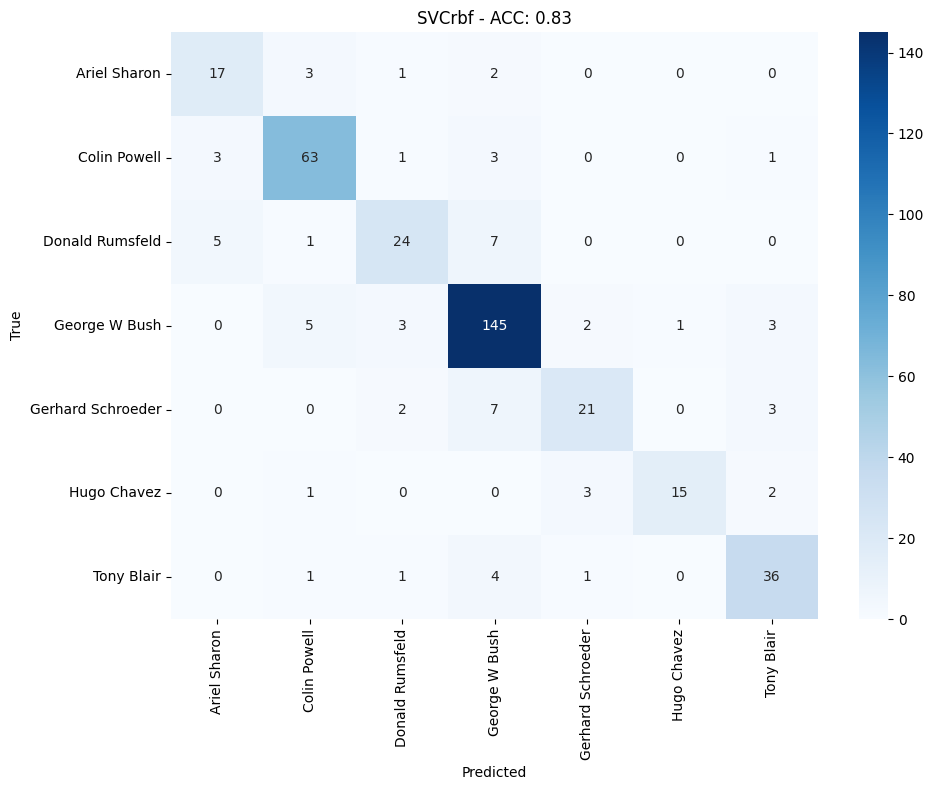

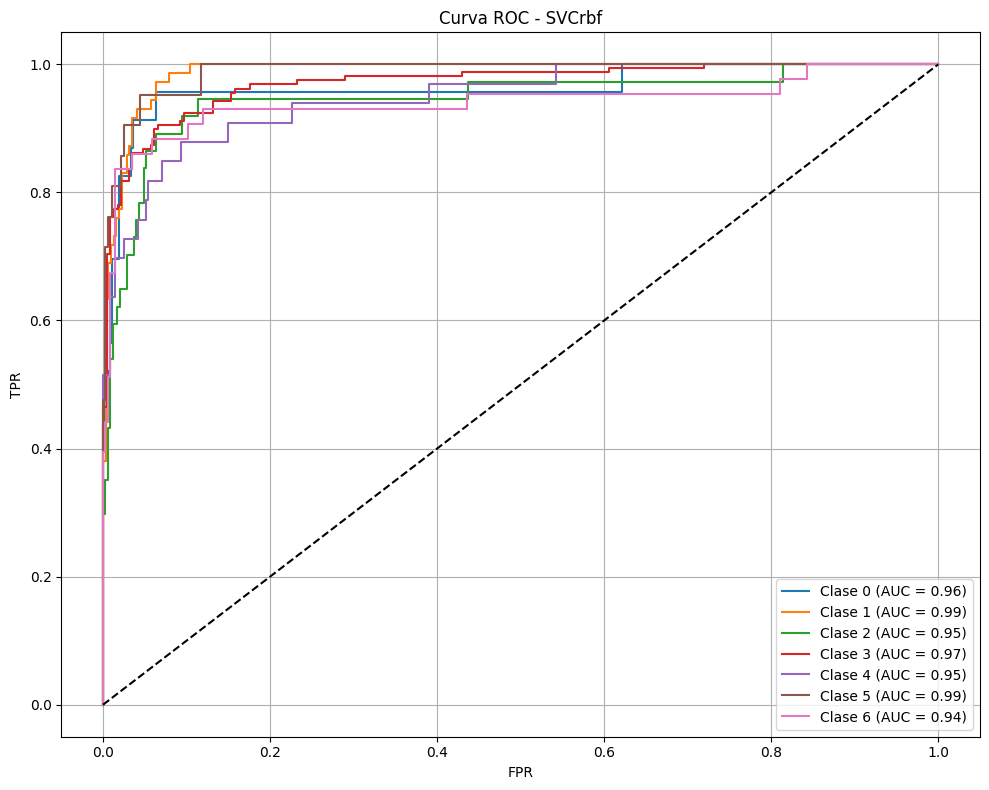


📌 RandomForest - ACC: 0.643
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.09      0.16        23
     Colin Powell       0.77      0.70      0.74        71
  Donald Rumsfeld       0.92      0.32      0.48        37
    George W Bush       0.58      0.97      0.73       159
Gerhard Schroeder       0.58      0.21      0.31        33
      Hugo Chavez       1.00      0.33      0.50        21
       Tony Blair       0.74      0.40      0.52        43

         accuracy                           0.64       387
        macro avg       0.80      0.43      0.49       387
     weighted avg       0.71      0.64      0.60       387



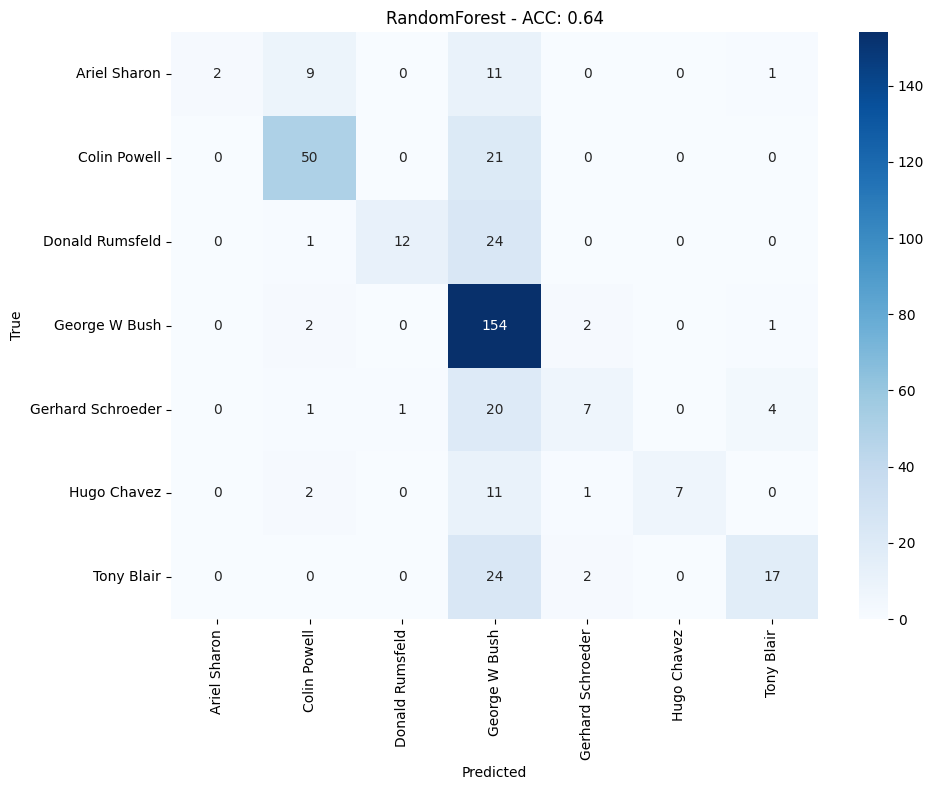

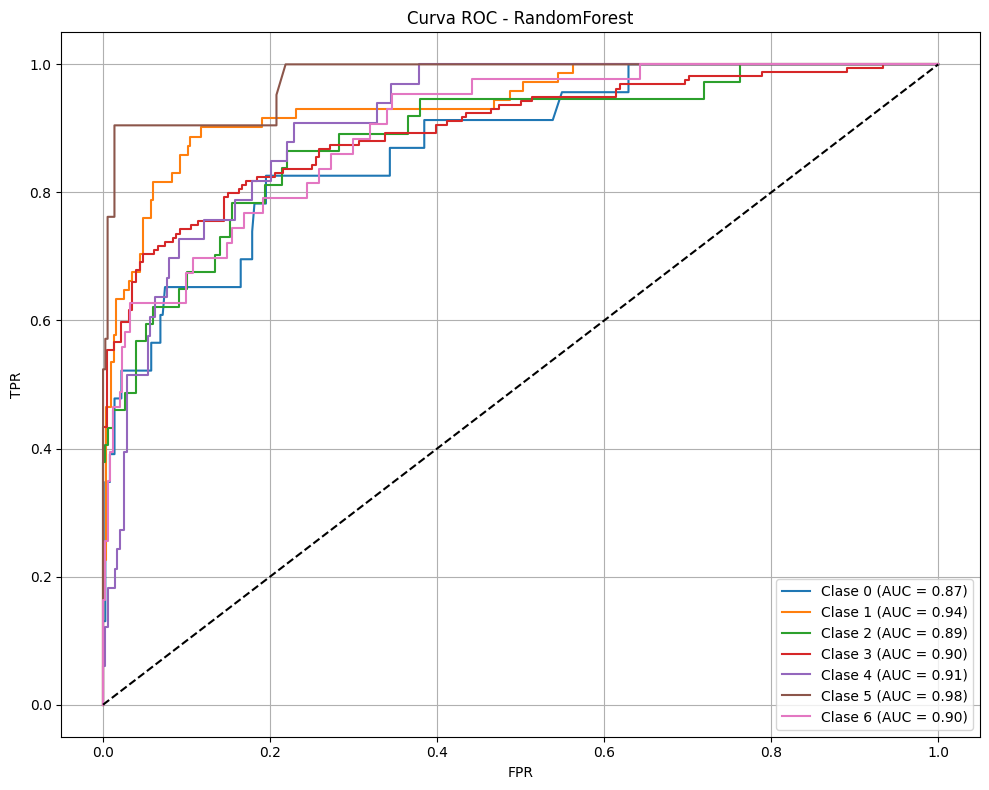


📌 NaiveBayes - ACC: 0.416
                   precision    recall  f1-score   support

     Ariel Sharon       0.33      0.43      0.38        23
     Colin Powell       0.51      0.51      0.51        71
  Donald Rumsfeld       0.47      0.49      0.48        37
    George W Bush       0.91      0.30      0.45       159
Gerhard Schroeder       0.17      0.33      0.23        33
      Hugo Chavez       0.23      0.71      0.35        21
       Tony Blair       0.33      0.53      0.41        43

         accuracy                           0.42       387
        macro avg       0.42      0.47      0.40       387
     weighted avg       0.60      0.42      0.43       387



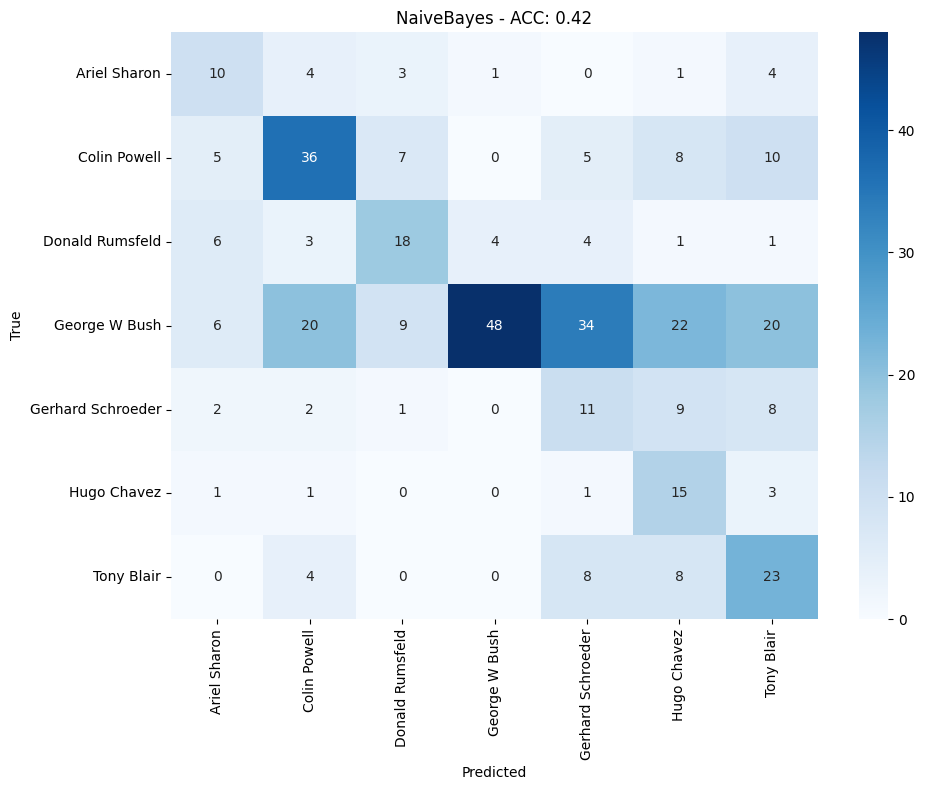

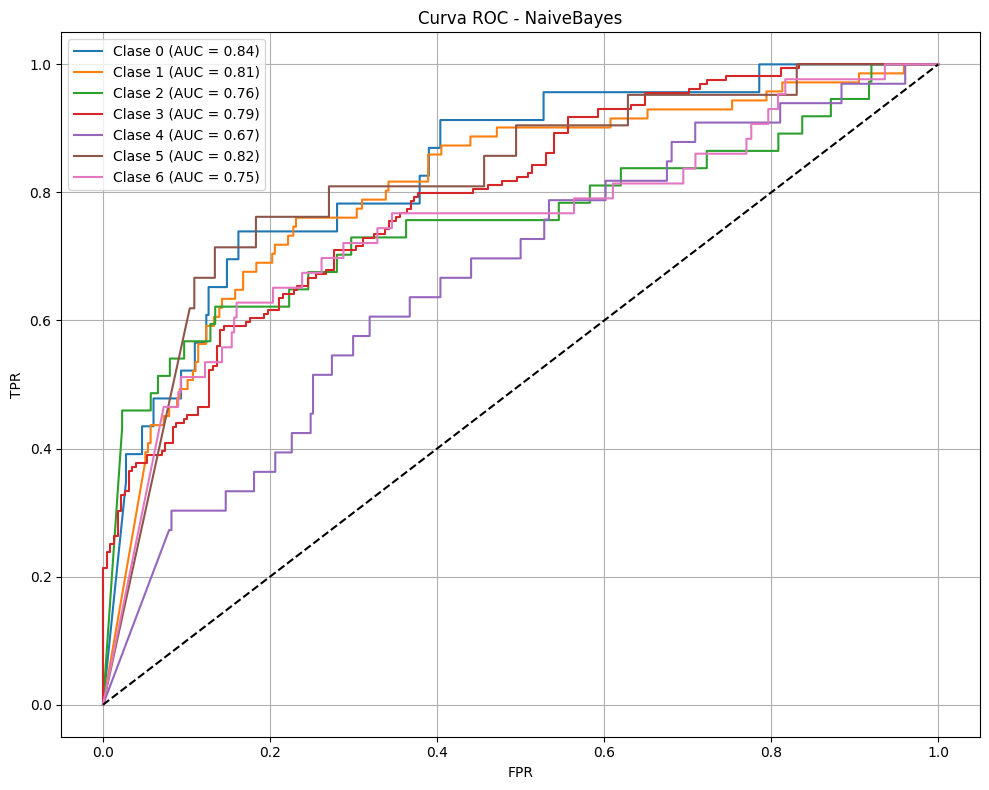


📌 LDA - ACC: 0.700
                   precision    recall  f1-score   support

     Ariel Sharon       0.69      0.39      0.50        23
     Colin Powell       0.73      0.68      0.70        71
  Donald Rumsfeld       0.56      0.65      0.60        37
    George W Bush       0.79      0.81      0.80       159
Gerhard Schroeder       0.54      0.58      0.56        33
      Hugo Chavez       0.58      0.71      0.64        21
       Tony Blair       0.68      0.63      0.65        43

         accuracy                           0.70       387
        macro avg       0.65      0.64      0.64       387
     weighted avg       0.70      0.70      0.70       387



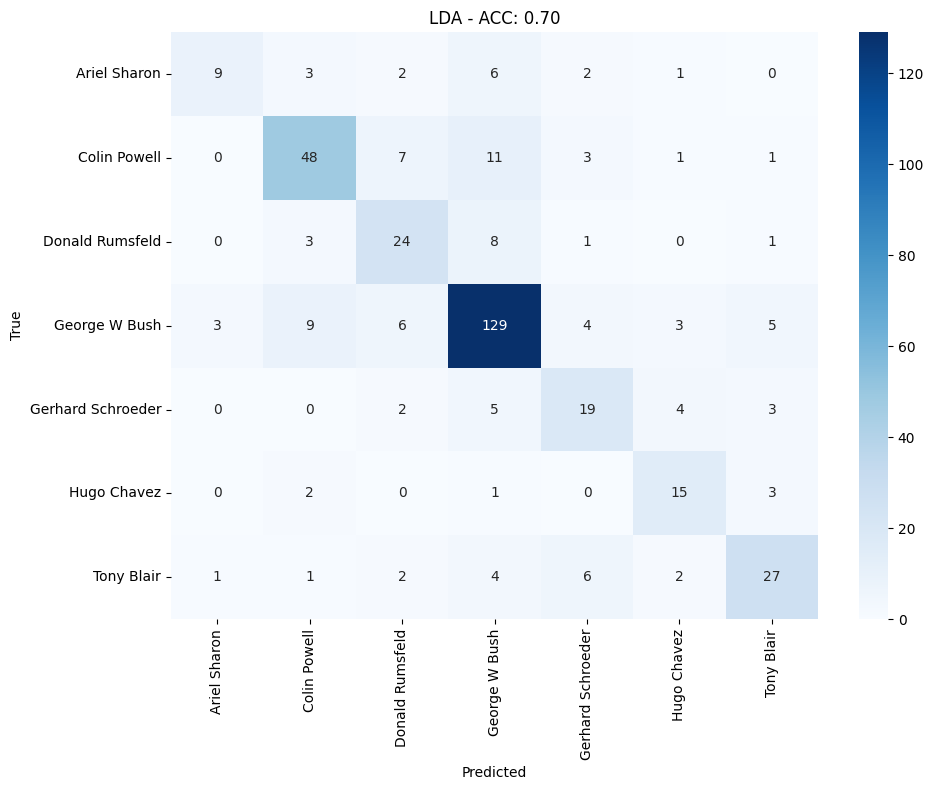

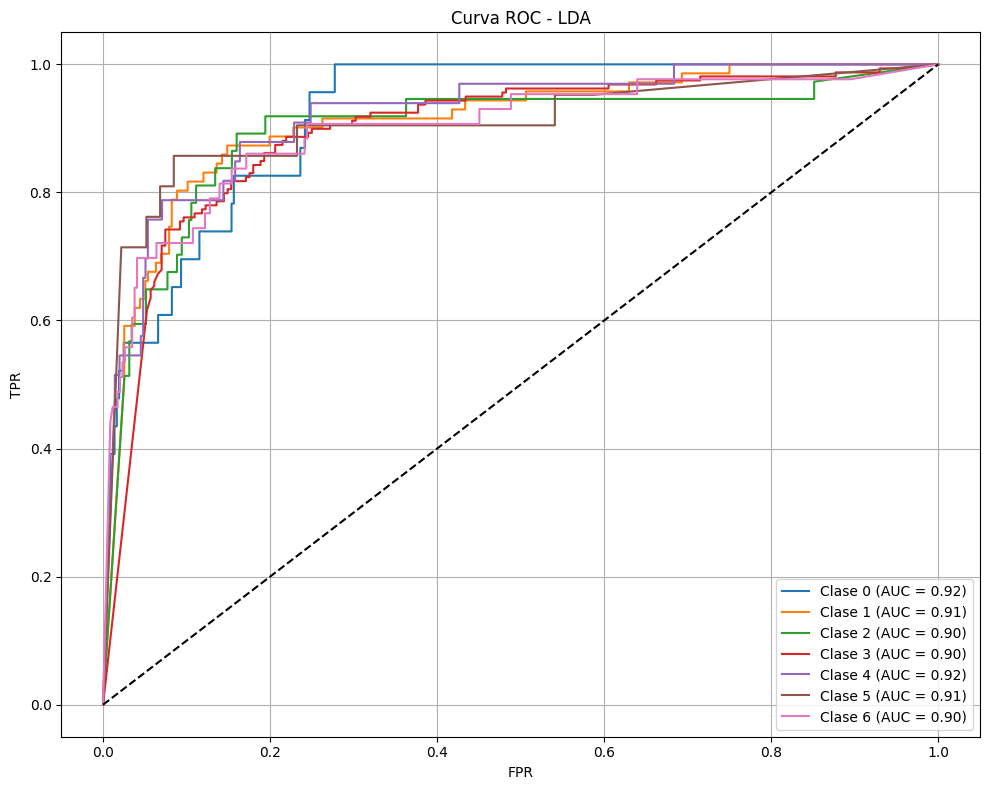


📌 KNN - ACC: 0.633
                   precision    recall  f1-score   support

     Ariel Sharon       0.80      0.35      0.48        23
     Colin Powell       0.58      0.66      0.62        71
  Donald Rumsfeld       0.68      0.41      0.51        37
    George W Bush       0.65      0.91      0.76       159
Gerhard Schroeder       0.43      0.27      0.33        33
      Hugo Chavez       0.75      0.14      0.24        21
       Tony Blair       0.72      0.42      0.53        43

         accuracy                           0.63       387
        macro avg       0.66      0.45      0.50       387
     weighted avg       0.64      0.63      0.60       387



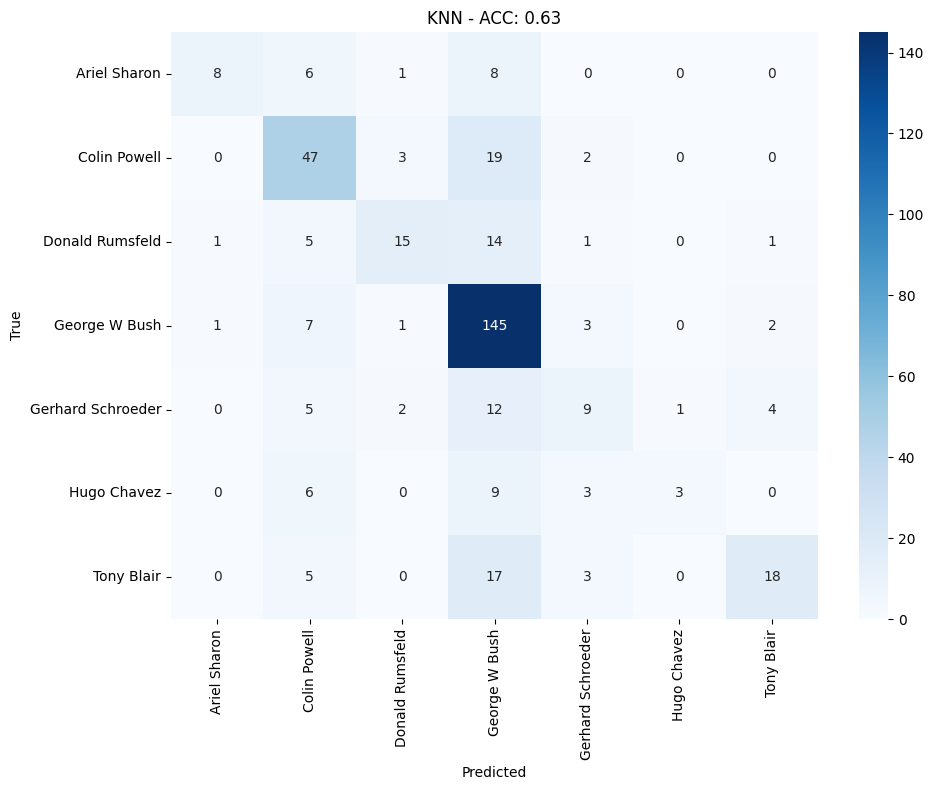

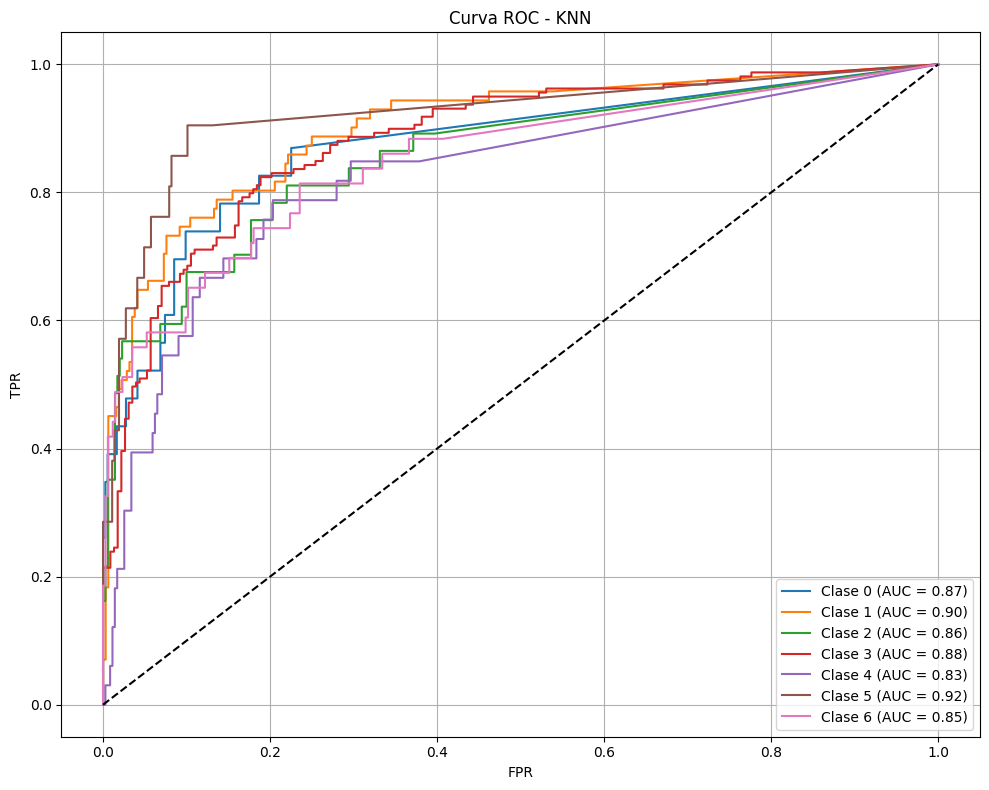

In [8]:
modelos_cargados = joblib.load('modelos_bayes_7.pkl')
ytest_bin = label_binarize(ytest, classes=np.unique(y))

for i, model in enumerate(modelos_cargados):
    name = label_models[i]
    est = model.best_estimator_ if hasattr(model, 'best_estimator_') else model
    y_pred = est.predict(Xtest)
    acc = accuracy_score(ytest, y_pred)

    print(f"\n📌 {name} - ACC: {acc:.3f}")
    print(classification_report(ytest, y_pred, target_names=lfw_people.target_names))
    plot_confusion_matrix(ytest, y_pred, lfw_people.target_names, title=f"{name} - ACC: {acc:.2f}")

    try:
        y_score = est.predict_proba(Xtest)
        if y_score.shape[1] == ytest_bin.shape[1]:
            roc_auc, fpr, tpr = roc_multiclass(ytest_bin, y_score)
            plot_roc_multiclass(fpr, tpr, roc_auc, name)
        else:
            print("⚠️ Clases no coinciden, se omite curva ROC.")
    except Exception as e:
        print(f"❌ No se pudo generar ROC para {name}: {e}")

In [9]:
from sklearn.metrics import f1_score, roc_auc_score

tabla_resultados = []

ytest_bin = label_binarize(ytest, classes=np.unique(y))

for i, model in enumerate(models):
    name = label_models[i]
    est = model.best_estimator_ if hasattr(model, 'best_estimator_') else model

    y_pred = est.predict(Xtest)
    acc = accuracy_score(ytest, y_pred)
    f1 = f1_score(ytest, y_pred, average='macro')

    try:
        y_score = est.predict_proba(Xtest)
        auc_score = roc_auc_score(ytest_bin, y_score, average='macro', multi_class='ovr')
    except:
        auc_score = np.nan

    tabla_resultados.append({
        'Modelo': name,
        'Accuracy': acc,
        'F1 Score': f1,
        'AUC Score': auc_score
    })

df_resultados = pd.DataFrame(tabla_resultados)
df_resultados = df_resultados.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
display(df_resultados)

,Modelo,Accuracy,F1 Score,AUC Score
0,Logistic,0.839793,0.796155,0.959003
1,SVCrbf,0.829457,0.784113,0.963549
2,SGD,0.751938,0.656618,NaN
3,LDA,0.700258,0.635316,0.907739
4,RandomForest,0.643411,0.489710,0.912070
5,KNN,0.633075,0.495953,0.873444
6,NaiveBayes,0.416021,0.401950,0.776425
